In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import subprocess
import sys
import io
import gradio as gr
import numpy as np
import random
import spaces
import torch
from diffusers import Flux2Pipeline, Flux2Transformer2DModel, FluxInpaintPipeline
from diffusers import BitsAndBytesConfig as DiffBitsAndBytesConfig
import requests
from PIL import Image
import json
import base64
from dotenv import load_dotenv
from huggingface_hub import login, InferenceClient
from helper_dev_utils import get_auto_logger
import sys
from pathlib import Path
import helper_plot_hangul
import importlib
import gc
import logging
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle
from typing import List, Optional, Tuple, Dict, Any
from helper_plot_hangul import matplotlib_font_reset, matplotlib_font_get
from helper_dev_utils import *
from diffusers.utils import load_image
logger = get_auto_logger()

In [3]:
# Hugging Face 로그인 (FLUX 모델 접근 권한 필요)
load_dotenv()

# 환경 변수에서 토큰 가져오기 또는 직접 입력
hf_token = os.getenv("HF_TOKEN")
logger.info(f"Hugging Face Token: {hf_token[:2]} ... {hf_token[-2:]}")

if hf_token:
    login(token=hf_token)
    logger.debug("✓ Logged in with HF_TOKEN from environment")
else:
    # 수동 로그인 (토큰 입력 필요)
    login()
    logger.debug("✓ Manual login completed")

2026-01-17 09:01:38 I [ipykernel_launcher:6] - Hugging Face Token: hf ... LA


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


2026-01-17 09:01:38 D [ipykernel_launcher:10] - ✓ Logged in with HF_TOKEN from environment


In [4]:
import sys
from pathlib import Path

# 프로젝트 경로 설정
project_root = Path.cwd().parent.parent / "src" / "nanoCocoa_aiserver"
sys.path.insert(0, str(project_root))
logger.debug(project_root)

import torch
import gc
from PIL import Image
from typing import Optional

from diffusers import DiffusionPipeline
from config import TORCH_DTYPE
from services.monitor import flush_gpu


2026-01-17 09:01:38 D [ipykernel_launcher:7] - /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver


In [5]:
import torch
import warnings
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from config import DEVICE, MODEL_IDS
from utils import flush_gpu

# timm 라이브러리 deprecation 경고 억제
warnings.filterwarnings("ignore", category=FutureWarning, module="timm")

class SegmentationModel:
    """
    BiRefNet을 사용하여 이미지 세그멘테이션(배경 제거)을 수행하는 클래스입니다.
    """
    def __init__(self):
        self.device = DEVICE

    def run(self, image: Image.Image) -> tuple[Image.Image, Image.Image]:
        """
        이미지의 배경을 제거합니다.
        
        Args:
            image (Image.Image): 입력 이미지
            
        Returns:
            tuple[Image.Image, Image.Image]: (배경 제거된 이미지, 마스크)
        """
        logger.debug("[Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)")
        flush_gpu()
        
        model = AutoModelForImageSegmentation.from_pretrained(
            MODEL_IDS["SEG"], trust_remote_code=True
        ).to(self.device).eval()

        W, H = image.size
        # 고해상도 처리를 위해 리사이즈 (필요 시 조정 가능)
        img_resized = image.resize((1024, 1024), Image.LANCZOS)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            preds = model(input_tensor)[-1].sigmoid().cpu()
        
        pred = preds[0].squeeze()
        mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
        
        # 마스크 이진화 (Thresholding)
        mask = mask.point(lambda x: 255 if x > 128 else 0)
        
        # 마스크 블러 처리 (외곽선 부드럽게)
        from PIL import ImageFilter
        mask = mask.filter(ImageFilter.GaussianBlur(radius=5))
        
        result = image.copy()
        result.putalpha(mask)
        
        # 리소스 정리
        del model, input_tensor
        flush_gpu()
        
        return result, mask


In [13]:
from models.flux_generator import FluxGenerator

fluxgenerator = FluxGenerator()
segmenter = SegmentationModel()
logger.debug("로딩 성공")

2026-01-17 09:19:23 I [flux_generator:37] - FluxGenerator initialized (pipelines will load on demand)
2026-01-17 09:19:23 D [ipykernel_launcher:5] - 로딩 성공


In [14]:
product_fg, product_mask = segmenter.run(Image.open("image02.png"))

2026-01-17 09:19:23 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)


In [15]:
# 2. 흐린 한국 맥주집 배경 생성 (만화풍)
background_prompt = """
A blurred, dreamy illustration of a cozy Korean beer pub (pocha) interior. 
Cartoon style, anime aesthetic, soft focus background with warm ambient lighting. 
Blurred hanging lanterns, wooden tables, and traditional decorations. 
Empty foreground space for product placement. 
Bokeh effect, shallow depth of field, cinematic atmosphere, 8k illustration.
"""

bg_image = fluxgenerator.generate_background(
    prompt=background_prompt,
    guidance_scale=3.5,
    seed=42,
    auto_unload=False
)


2026-01-17 09:19:35 I [flux_generator:141] - [FluxGenerator] Generating background with Text-to-Image...
2026-01-17 09:19:35 I [flux_generator:60] - [FluxGenerator] Loading FLUX Text-to-Image pipeline...
2026-01-17 09:19:35 I [flux_generator:44] - [FluxGenerator] Loading 8bit quantized Transformer...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2026-01-17 09:22:06 I [flux_generator:52] - [FluxGenerator] Transformer loaded with 8bit quantization


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-17 09:22:12 I [flux_generator:73] - [FluxGenerator] Text-to-Image pipeline ready
2026-01-17 09:22:12 I [flux_generator:161] -  [FluxGenerator] prompt='
A blurred, dreamy illustration of a cozy Korean beer pub (pocha) interior. 
Cartoon style, anime aesthetic, soft focus background with warm ambient lighting. 
Blurred hanging lanterns, wooden tables, and traditional decorations. 
Empty foreground space for product placement. 
Bokeh effect, shallow depth of field, cinematic atmosphere, 8k illustration.
' 
2026-01-17 09:22:12 I [flux_generator:162] -  [FluxGenerator] negative_prompt='None' 


  0%|          | 0/25 [00:00<?, ?it/s]

The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-17 09:24:17 I [flux_generator:175] - [FluxGenerator] Background generation completed


2026-01-17 09:32:36 I [flux_generator:60] - [FluxGenerator] Injecting features via Inpainting...
2026-01-17 09:32:36 I [flux_generator:102] - [FluxGenerator] Loading FLUX Inpaint pipeline...
2026-01-17 09:32:36 I [flux_generator:44] - [FluxGenerator] Loading 8bit quantized Transformer...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2026-01-17 09:34:42 I [flux_generator:52] - [FluxGenerator] Transformer loaded with 8bit quantization


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-17 09:34:48 I [flux_generator:115] - [FluxGenerator] Inpaint pipeline ready
2026-01-17 09:34:48 I [flux_generator:83] - [FluxGenerator] Product scaled: original=(800, 705), scaled=(768, 676), scale=0.75
2026-01-17 09:34:48 I [flux_generator:105] - [FluxGenerator] Text position 'centor' resolved to coordinates: (128, 174)
2026-01-17 09:34:49 I [flux_generator:117] - [FluxGenerator] Injecting features: prompt='
Photorealistic details of the input subject, razo...', strength=0.3
2026-01-17 09:34:49 I [flux_generator:118] -  [FluxGenerator] prompt='
Photorealistic details of the input subject, razor-sharp focus on the product contrasting with a blurred cartoon style background. Professional food photography lighting, 8k resolution, masterpiece quality.
' 
2026-01-17 09:34:49 I [flux_generator:119] -  [FluxGenerator] negative_prompt='blurry product, soft focus product, cartoon fish, unrealistic' 


  0%|          | 0/9 [00:00<?, ?it/s]

/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-17 09:36:15 I [flux_generator:121] - [FluxGenerator] Feature injection completed
2026-01-17 09:36:15 I [config:55] - [FluxGenerator unload (before)] GPU Memory: allocated=11.13GB, reserved=11.18GB
2026-01-17 09:36:36 I [config:55] - [FluxGenerator unload (after)] GPU Memory: allocated=0.01GB, reserved=0.05GB
2026-01-17 09:36:36 I [flux_generator:213] - FluxGenerator unloaded (all pipelines cleared)


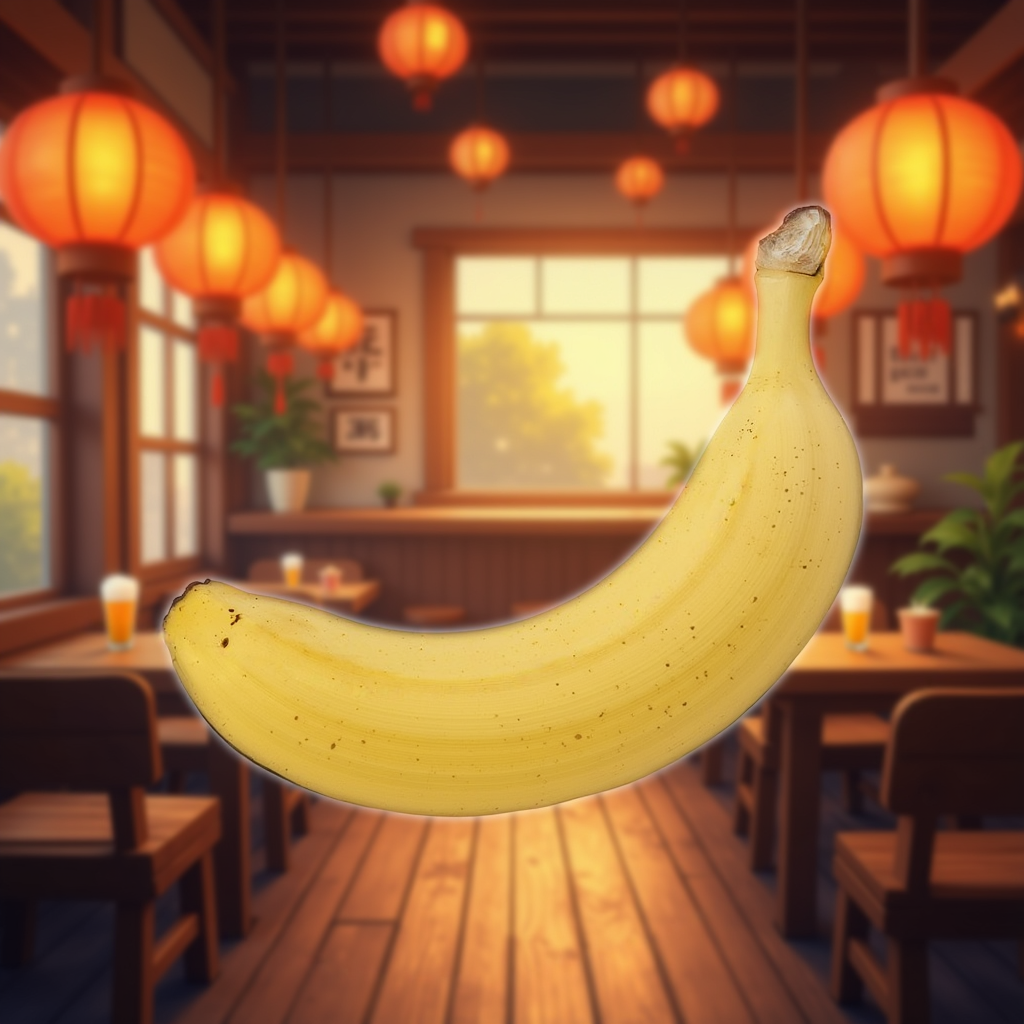

In [17]:

# 3. 노가리 이미지 로드 (배경 제거된 RGBA)
product_image = product_fg.convert("RGBA")
product_mask = product_image.split()[3]  # 알파 채널을 마스크로 사용

# 4. 이미지 선명하게 유지하면서 배경에 합성
product_prompt = """
Photorealistic details of the input subject, razor-sharp focus on the product contrasting with a blurred cartoon style background. Professional food photography lighting, 8k resolution, masterpiece quality.
"""

final_image = fluxgenerator.inject_features_via_inpaint(
    background=bg_image,
    product_foreground=product_image,
    product_mask=product_mask,
    position="centor",
    prompt=product_prompt,
    negative_prompt="blurry product, soft focus product, cartoon fish, unrealistic",
    strength=0.3,  # 낮은 값 = 노가리 원본 유지
    guidance_scale=4.0,
    seed=42,
    auto_unload=False
)

fluxgenerator.unload()

#final_image.save("nogari_ad.png")
final_image.show()